In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier


In [3]:
df = pd.read_csv('/content/parkinsons.csv')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


# Identify and Remove Outliers

In [6]:
Q1 = df.quantile(0.25)  # Source: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
Q3 = df.quantile(0.75)  # Calculating Q1, Q3 and the Interquartile Range
IQR = Q3 - Q1
print(IQR)

MDVP:Fo(Hz)         65.197000
MDVP:Fhi(Hz)        89.343000
MDVP:Flo(Hz)        55.727500
MDVP:Jitter(%)       0.003905
MDVP:Jitter(Abs)     0.000040
MDVP:RAP             0.002175
MDVP:PPQ             0.002095
Jitter:DDP           0.006520
MDVP:Shimmer         0.021380
MDVP:Shimmer(dB)     0.201500
Shimmer:APQ3         0.012020
Shimmer:APQ5         0.012800
MDVP:APQ             0.016320
Shimmer:DDA          0.036060
NHR                  0.019715
HNR                  5.877500
status               0.000000
RPDE                 0.166256
DFA                  0.087124
spread1              1.403904
spread2              0.104883
D2                   0.537330
PPE                  0.115529
dtype: float64


In [7]:
print(df < (Q1 - 1.5 * IQR)) or (df > (Q3 + 1.5 * IQR))  # Source: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba


        D2    DFA    HNR  Jitter:DDP  ...   name  spread1  spread2  status
0    False  False  False       False  ...  False    False    False   False
1    False  False  False       False  ...  False    False    False   False
2    False  False  False       False  ...  False    False    False   False
3    False  False  False       False  ...  False    False    False   False
4    False  False  False       False  ...  False    False    False   False
..     ...    ...    ...         ...  ...    ...      ...      ...     ...
190  False  False  False       False  ...  False    False    False    True
191  False  False  False       False  ...  False    False    False    True
192  False  False  False       False  ...  False    False    False    True
193  False  False  False       False  ...  False    False    False    True
194  False  False  False       False  ...  False    False    False    True

[195 rows x 24 columns]


,D2,DFA,HNR,Jitter:DDP,MDVP:APQ,MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Fo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:PPQ,MDVP:RAP,MDVP:Shimmer,MDVP:Shimmer(dB),NHR,PPE,RPDE,Shimmer:APQ3,Shimmer:APQ5,Shimmer:DDA,name,spread1,spread2,status
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
191,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
192,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
193,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [9]:
df_ready = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)] # This code (also from source above) creates a 
df_ready.shape

(114, 24)

Histograms of features with outliers removed:

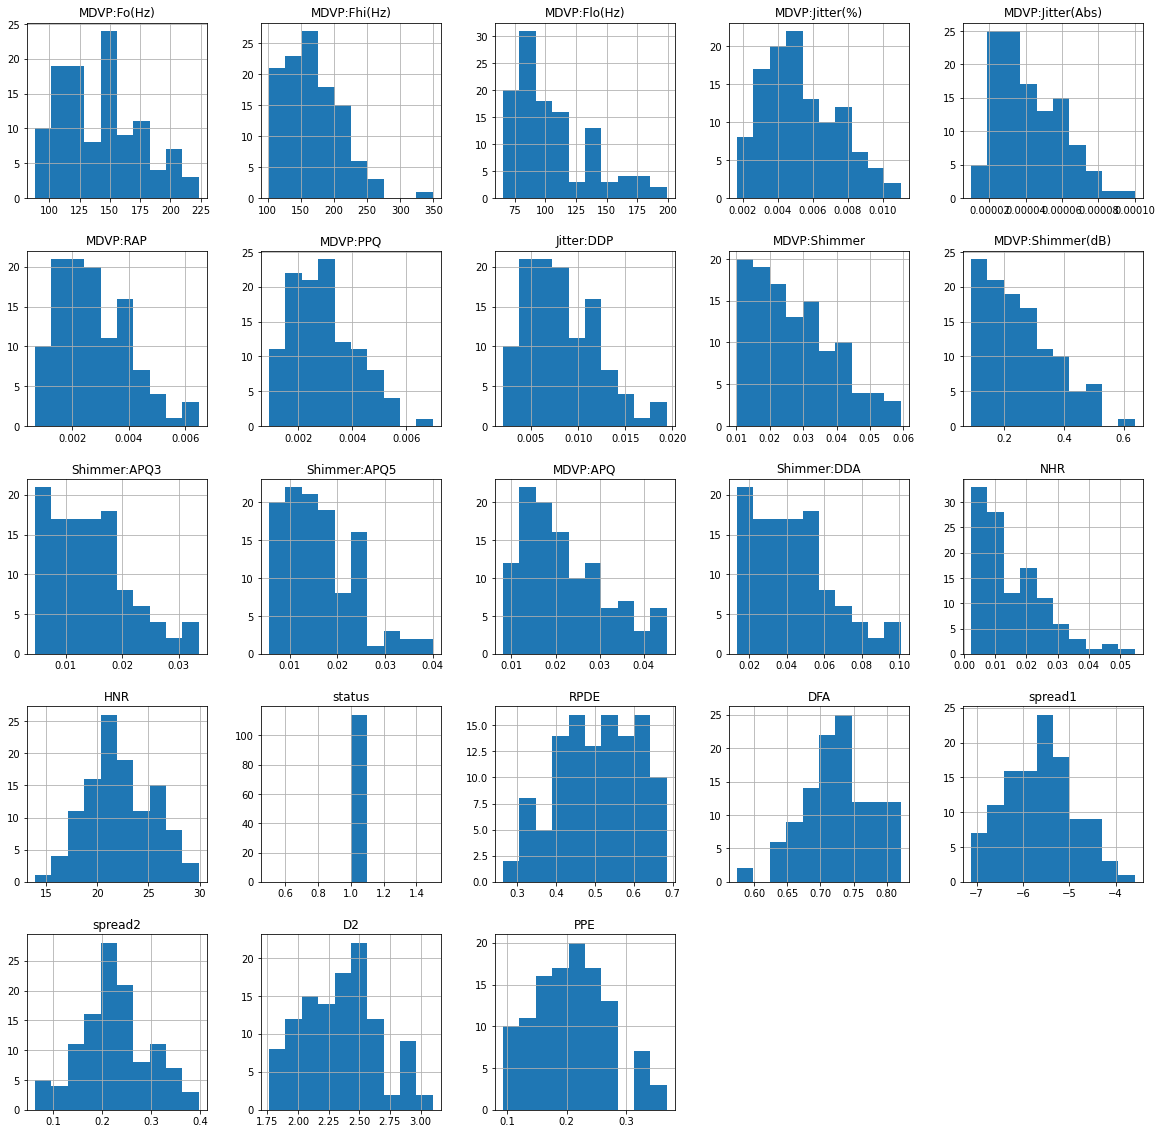

In [10]:
df_ready.hist(figsize = (20,20));    # Outliers removed

The shapes of the histograms on features with outliers removed (above) are more regular than the shapes of the histograms where data was averaged before removing outliers. Need to look at whether data set contains both PD diagnosis and not PD samples after removing outliers.

In [11]:
df_ready['status'].value_counts()

1    114
Name: status, dtype: int64

Data set no longer has non PD samples after outliers were removed.  Outliers will not be removed for further modeling.